In [1]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import random
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from keras.metrics import Precision, Recall, F1Score
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model, to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from hashlib import md5

2025-04-12 03:47:12.947767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744429633.141695      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744429633.197630      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
def df_shrink(df, obj2cat=False, int2uint=False):
    # Giảm bộ nhớ cho DataFrame
    
    df_copy = df.copy()
    
    # Xử lý các cột integer
    for col in df_copy.select_dtypes(include=['int64']).columns:
        if int2uint:
            # Chuyển sang unsigned integer nếu được bật
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='unsigned')
        else:
            # Chuyển sang integer nhỏ hơn
            df_copy[col] = pd.to_numeric(df_copy[col], downcast='integer')
    
    # Xử lý các cột float
    for col in df_copy.select_dtypes(include=['float64']).columns:
        df_copy[col] = pd.to_numeric(df_copy[col], downcast='float')
    
    # Chuyển đổi các cột object sang category nếu được bật
    if obj2cat:
        for col in df_copy.select_dtypes(include=['object']).columns:
            df_copy[col] = df_copy[col].astype('category')
    
    return df_copy

In [3]:
# Function to create a hash for each column
def hash_column(series):
    return md5(pd.util.hash_pandas_object(series, index=False).values).hexdigest()

# Function to find columns with identical hashes
def find_identical_columns_by_hash(df):
    hash_dict = {}
    for col in df.columns:
        col_hash = hash_column(df[col])
        if col_hash in hash_dict:
            hash_dict[col_hash].append(col)
        else:
            hash_dict[col_hash] = [col]

    return [cols for cols in hash_dict.values() if len(cols) > 1]


In [4]:
# Tải và tiền xử lý dữ liệu
def load_and_preprocess_data():
    # Đọc dữ liệu
    print("Loading data...")
    df = pd.read_csv("/kaggle/input/iot-attack/processed_IIoT.csv")
    df.info()

    # Phân tích dữ liệu ban đầu
    print("\nInitial data analysis:")
    print(f"Total samples: {len(df)}")
    print("\nClass distribution:")
    print(df['Attack_type'].value_counts())

    # Xử lý dữ liệu 

    # Applying the hash function to the DataFrame
    identical_column_groups = find_identical_columns_by_hash(df)
    print("Groups of identical columns:", identical_column_groups)
    
    # Iterate through the list of groups and drop all 
    for group in identical_column_groups:
        df = df.drop(group, axis=1)
        
    df = df_shrink(df, obj2cat=False, int2uint=False)
    print("Data info after shrinking memory:")
    df.info()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)   
    df.dropna(axis=0, how='any', inplace=True)
    df.drop_duplicates(subset=None, keep="first", inplace=True)
    df = shuffle(df)

    # Chuyển đổi các cột không phải số thành số bằng Label Encoding
    for column in df.select_dtypes(include=['object']).columns:
      df[column] = df[column].astype(str)
      le = LabelEncoder()
      df[column] = le.fit_transform(df[column])
    
    # Tách features và target
    X = df.drop(['Attack_type'], axis=1)
    y = df['Attack_type']

    print(f"Features after removal: {X.shape[1]}")
    
    # One-hot encoding cho target
    y = to_categorical(y)

    return X, y

In [5]:
# Tiền xử lý dữ liệu
X, y = load_and_preprocess_data()

# Chia dữ liệu thành tập huấn luyện, kiểm tra và xác thực
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42, stratify=y_train)

# Chuẩn hóa các đặc trưng
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Reshape cho CNN (thêm channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# In thông tin về shape của data
print("\nData shapes:")
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
    
# Kiểm tra phân phối classes trong từng tập
print("\nClass distribution in splits:")
print("Training set:", np.sum(y_train, axis=0))
print("Validation set:", np.sum(y_val, axis=0))
print("Test set:", np.sum(y_test, axis=0))

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921663 entries, 0 to 1921662
Data columns (total 96 columns):
 #   Column                                                                                                Dtype  
---  ------                                                                                                -----  
 0   arp.opcode                                                                                            float64
 1   arp.hw.size                                                                                           float64
 2   icmp.checksum                                                                                         float64
 3   icmp.seq_le                                                                                           float64
 4   icmp.unused                                                                                           float64
 5   http.content_length                                          

In [6]:
# Định nghĩa kích thước đầu vào và số lớp đầu ra
input_shape = (X_train.shape[1], 1)
output_classes = 15

In [7]:
# Hàm tạo mô hình CNN 1D
def create_1d_cnn_model(params):
    model = Sequential()
    model.add(Conv1D(filters=params['num_filters'], 
                             kernel_size=params['kernel_size'], 
                             activation='relu', 
                             input_shape=(input_shape),
                             padding='same'))
    model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))
    model.add(Conv1D(filters=params['num_filters'], 
                             kernel_size=params['kernel_size'], 
                             activation='relu',
                             padding='same'))
    model.add(MaxPooling1D(pool_size=params['pooling_size'], padding='same'))

    model.add(Dropout(params['dropout_rate']))
    model.add(Flatten())

    for _ in range(params['num_dense_layers']):
        model.add(Dense(params['num_neurons_in_dense_layers'], activation='relu'))
        model.add(Dropout(params['dropout_rate']))

    model.add(Dense(output_classes, activation='softmax'))

    optimizer = Adam(learning_rate=params['learning_rate'])
    loss_function = 'categorical_crossentropy'
    model.compile(loss=loss_function, optimizer=optimizer,
                 metrics=['accuracy', Precision(), Recall(), F1Score()])

    return model

In [8]:
# Thông số PSO
n_particles = 5
n_iterations = 8
c1 = 2
c2 = 2
bounds = [
    (0, 2),      # num_filters
    (0, 2),      # kernel_size
    (2, 5),      # pooling_size
    (1, 3),      # num_dense_layers 
    (0, 2),      # num_neurons_in_dense_layers
    (0.1, 0.5),  # dropout_rate
    (1e-5, 1e-2),# learning_rate
    (0, 4),      # batch_size
    (20, 50)     # num_epochs
]
particles = [np.random.uniform(low=bounds[i][0], high=bounds[i][1], size=n_particles) for i in range(len(bounds))]
velocities = [np.zeros(n_particles) for _ in range(len(bounds))]

In [9]:
# Chuyển vị trí thành tham số
def position_to_params(particles, i):
    params_keys = ['num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs']
    params = {}
    for j, key in enumerate(params_keys):
        value = particles[j][i]
        if key in ['num_filters', 'kernel_size', 'pooling_size', 
                   'num_dense_layers', 'num_neurons_in_dense_layers', 
                   'batch_size', 'num_epochs']:  
            value = int(round(value))
        if key == 'num_filters':
            value_choices = [16, 32, 64]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'num_neurons_in_dense_layers':
            value_choices = [128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'batch_size':
            value_choices = [32, 64, 128, 256, 512]
            value = value_choices[min(int(value), len(value_choices)-1)]
        if key == 'kernel_size':
            value_choices = [3, 5, 7]
            value = value_choices[min(int(value), len(value_choices)-1)]
        params[key] = value
    return params

In [10]:
# Khởi tạo vị trí tốt nhất cá nhân và vị trí tốt nhất toàn cục
pbest_positions = [position_to_params(particles, i) for i in range(n_particles)]
pbest_fitnesses = [0] * n_particles
gbest_position = None
gbest_fitness = None

In [11]:
# Định nghĩa callback tùy chỉnh để theo dõi thời gian huấn luyện
class TimingCallback(keras.callbacks.Callback):
    def __init__(self):
        super(TimingCallback, self).__init__()
        self.epoch_times = []  # Lưu thời gian của từng epoch
        self.total_time = 0.0  # Tổng thời gian huấn luyện

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()  # Ghi lại thời gian bắt đầu của epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time  # Tính thời gian của epoch
        self.epoch_times.append(epoch_time)  # Lưu thời gian của epoch
        self.total_time += epoch_time  # Cộng dồn vào tổng thời gian
        print(f"\nThời gian huấn luyện cho epoch {epoch+1}: {epoch_time:.2f} giây")

    def on_train_end(self, logs=None):
        print(f"\nTổng thời gian huấn luyện cho vòng lặp: {self.total_time:.2f} giây")

In [12]:
# Hàm đánh giá độ thích nghi
def evaluate_fitness(params, particle_id=None, iteration=None):
    
    print(f"{'='*50}")
    if particle_id is not None and iteration is not None:
        print(f"Vòng lặp {iteration+1}, Cá thể {particle_id+1}")
    print("Tham số:")
    for key, value in params.items():
        print(f"{key}: {value}")
        
    model = create_1d_cnn_model(params)
    model.summary()

    # Tạo callback để theo dõi thời gian huấn luyện
    timing_callback = TimingCallback()

    # Huấn luyện và đánh giá mô hình trên tập validation
    history = model.fit(X_train, y_train, 
                        batch_size=params['batch_size'], 
                        epochs=params['num_epochs'], 
                        verbose=1, 
                        validation_data=(X_val, y_val), 
                        callbacks=timing_callback, 
                        shuffle=True)
    
    # Lấy lịch sử huấn luyện
    metrics_history = history.history

    # In danh sách các giá trị val_accuracy qua các epoch
    print("Danh sách các giá trị val_accuracy qua các epoch:")
    print(metrics_history['val_accuracy'])
    
    # Lấy giá trị val_accuracy tại epoch cuối cùng
    val_acc_value = metrics_history['val_accuracy'][-1]
    print(f"Giá trị val accuracy tại epoch cuối: {val_acc_value}")

    # Chuyển đổi sang float để đảm bảo tính toán chính xác
    val_acc_value = float(val_acc_value)

    # Lấy thời gian huấn luyện tổng cộng
    exec_time = timing_callback.total_time

    # Tính toán các thành phần fitness 
    lambda_value = 0.5  # λ = 0.5
    k = 0.001
    fitness_accuracy_component = val_acc_value
    fitness_time_component = 1 / np.exp(k * exec_time)
            
    # Tính fitness tổng hợp: F = λ.Acc + (1-λ).(1/e^(k*T))
    fitness = lambda_value * fitness_accuracy_component + (1 - lambda_value) * fitness_time_component
        
    print(f"\nĐánh giá fitness:")
    print(f"Thành phần accuracy: {lambda_value} * {fitness_accuracy_component:.4f} = {lambda_value * fitness_accuracy_component:.4f}")
    print(f"Thành phần thời gian: {1-lambda_value} * {fitness_time_component:.4f} = {(1-lambda_value) * fitness_time_component:.4f}")
    print(f"Fitness tổng hợp: {fitness:.4f}")

    # Lưu mô hình sau khi huấn luyện và đánh giá xong
    model_save_path = f"model_iter_{iteration+1}_part_{particle_id+1}.h5"
    print("\nĐang lưu mô hình sau khi huấn luyện xong...")
    model.save(model_save_path)
    print(f"Mô hình đã được lưu thành công tại: {model_save_path}\n")
    
    return {
        'model': model,
        'fitness': fitness,
        'history': metrics_history,
        'total_time': timing_callback.total_time
    }

In [13]:
best_model = None
best_model_path = 'best_1d-cnn-pso_model.h5'
best_model_history = None

# Bắt đầu đo thời gian
start_time = time.time()

# Tối ưu hóa PSO
params_keys = ['num_filters', 
               'kernel_size', 
               'pooling_size', 
               'num_dense_layers', 
               'num_neurons_in_dense_layers', 
               'dropout_rate', 
               'learning_rate', 
               'batch_size', 
               'num_epochs']

print("=== Khởi tạo quần thể ===")
print("=== Bắt đầu quá trình tối ưu hóa PSO ===")

# Khởi tạo biến theo dõi 
previous_gbest_fitness = None
    
for iteration in range(n_iterations):
    print(f"\nVòng lặp {iteration + 1}")
    
    for i in range(n_particles):
        params = position_to_params(particles, i)
        result = evaluate_fitness(params, i, iteration)
        fitness = result['fitness']

        if fitness > pbest_fitnesses[i]:
            pbest_fitnesses[i] = fitness
            pbest_positions[i] = params.copy()
            print(f"Cập nhật pbest cho cá thể {i+1}: {fitness:.4f}")

        if gbest_fitness is None or fitness > gbest_fitness:
            gbest_fitness = fitness
            gbest_position = params.copy()
            best_model = result['model']
            best_model.save(best_model_path, overwrite=True)
            best_model_history = result['history']
            print(f"Cập nhật gbest: {fitness:.4f}")
            
    print(f"\nKết quả sau vòng lặp tối ưu {iteration + 1}:")

    # Kiểm tra kết quả
    if previous_gbest_fitness is not None:
        improvement = gbest_fitness - previous_gbest_fitness
        if improvement > 0:
            if improvement <= 1e-4:
                print(f"Độ cải thiện không đáng kể (nhỏ hơn ngưỡng 1e-4)")
            else:
                print(f"Best fitness global: {gbest_fitness:.4f}")
                print("Best parameters global:")
                for key, value in gbest_position.items():
                    print(f"{key}: {value}")
                print(f"Độ cải thiện so với vòng lặp trước: {improvement:.4f}")
        else:
            print("Không có sự cải thiện so với vòng lặp trước")
    else:
        print(f"Best fitness global: {gbest_fitness:.4f}")
        print("Best parameters global:")
        for key, value in gbest_position.items():
            print(f"{key}: {value}")
    
    previous_gbest_fitness = gbest_fitness
    
    for i in range(n_particles):
        for j, key in enumerate(params_keys):
            r1, r2 = np.random.random(), np.random.random()
            velocities[j][i] = 0.5 * velocities[j][i] + c1 * r1 * (pbest_positions[i][key] - particles[j][i]) + c2 * r2 * (gbest_position[key] - particles[j][i])
            particles[j][i] += velocities[j][i]
            particles[j][i] = np.clip(particles[j][i], bounds[j][0], bounds[j][1])

# Kết thúc đo thời gian
end_time = time.time()

# Tính và in ra thời gian thực thi
execution_time = end_time - start_time
print(f"\nThời gian thực thi tổng thể: {execution_time:.2f} giây")

=== Khởi tạo quần thể ===
=== Bắt đầu quá trình tối ưu hóa PSO ===

Vòng lặp 1
Vòng lặp 1, Cá thể 1
Tham số:
num_filters: 64
kernel_size: 7
pooling_size: 2
num_dense_layers: 2
num_neurons_in_dense_layers: 512
dropout_rate: 0.10425090397380395
learning_rate: 0.0001017526841915693
batch_size: 512
num_epochs: 25


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744429718.230540      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744429718.231186      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,021,007 (3.89 MB)

 Trainable params: 1,021,007 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25


I0000 00:00:1744429724.492732      63 service.cc:148] XLA service 0x79882800db30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744429724.493326      63 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744429724.493350      63 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744429724.822787      63 cuda_dnn.cc:529] Loaded cuDNN version 90300


  17/2628 ━━━━━━━━━━━━━━━━━━━━ 27s 10ms/step - accuracy: 0.5012 - f1_score: 0.0575 - loss: 2.5026 - precision: 0.3645 - recall: 9.5302e-04

I0000 00:00:1744429729.011452      63 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9023 - f1_score: 0.5461 - loss: 0.3264 - precision: 0.9439 - recall: 0.8371
Thời gian huấn luyện cho epoch 1: 30.65 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.9023 - f1_score: 0.5462 - loss: 0.3263 - precision: 0.9439 - recall: 0.8371 - val_accuracy: 0.9326 - val_f1_score: 0.6566 - val_loss: 0.1428 - val_precision: 0.9677 - val_recall: 0.9078
Epoch 2/25
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9328 - f1_score: 0.6668 - loss: 0.1439 - precision: 0.9648 - recall: 0.9080
Thời gian huấn luyện cho epoch 2: 17.86 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9328 - f1_score: 0.6668 - loss: 0.1439 - precision: 0.9648 - recall: 0.9080 - val_accuracy: 0.9336 - val_f1_score: 0.6522 - val_loss: 0.1352 - val_precision: 0.9691 - val_recall: 0.9080
Epoch 3/25
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9345 - f1_score: 0.6867 - loss: 0.1366 - precision: 0.9690 - recall: 0.9087
T

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 86, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 18, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 18, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 604,399 (2.31 MB)

 Trainable params: 604,399 (2.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8226 - f1_score: 0.3119 - loss: 0.4797 - precision_1: 0.9583 - recall_1: 0.7487
Thời gian huấn luyện cho epoch 1: 77.48 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 77s 3ms/step - accuracy: 0.8226 - f1_score: 0.3119 - loss: 0.4797 - precision_1: 0.9583 - recall_1: 0.7487 - val_accuracy: 0.7990 - val_f1_score: 0.1269 - val_loss: 0.5022 - val_precision_1: 0.9974 - val_recall_1: 0.7098
Epoch 2/30
21014/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7702 - f1_score: 0.1436 - loss: 0.6751 - precision_1: 0.9898 - recall_1: 0.6743
Thời gian huấn luyện cho epoch 2: 65.93 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - accuracy: 0.7702 - f1_score: 0.1436 - loss: 0.6751 - precision_1: 0.9898 - recall_1: 0.6743 - val_accuracy: 0.7098 - val_f1_score: 0.0554 - val_loss: 0.9175 - val_precision_1: 1.0000 - val_recall_1: 0.6231
Epoch 3/30
21001/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7092 - f1_score: 0.0553 - loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 86, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 22, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,607 (228.93 KB)

 Trainable params: 58,607 (228.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/39
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9232 - f1_score: 0.6140 - loss: 0.1897 - precision_2: 0.9595 - recall_2: 0.8946
Thời gian huấn luyện cho epoch 1: 63.71 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 64s 3ms/step - accuracy: 0.9232 - f1_score: 0.6140 - loss: 0.1897 - precision_2: 0.9595 - recall_2: 0.8946 - val_accuracy: 0.9352 - val_f1_score: 0.6693 - val_loss: 0.1364 - val_precision_2: 0.9772 - val_recall_2: 0.9013
Epoch 2/39
21008/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9332 - f1_score: 0.6777 - loss: 0.1510 - precision_2: 0.9689 - recall_2: 0.9079
Thời gian huấn luyện cho epoch 2: 55.30 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 55s 3ms/step - accuracy: 0.9332 - f1_score: 0.6777 - loss: 0.1510 - precision_2: 0.9689 - recall_2: 0.9079 - val_accuracy: 0.9356 - val_f1_score: 0.6817 - val_loss: 0.1331 - val_precision_2: 0.9724 - val_recall_2: 0.9120
Epoch 3/39
21017/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9350 - f1_score: 0.6884 - loss: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 86, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 22, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,287 (477.68 KB)

 Trainable params: 122,287 (477.68 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/36
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9232 - f1_score: 0.6174 - loss: 0.1919 - precision_3: 0.9604 - recall_3: 0.8945
Thời gian huấn luyện cho epoch 1: 27.21 giây
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 27s 4ms/step - accuracy: 0.9232 - f1_score: 0.6174 - loss: 0.1919 - precision_3: 0.9604 - recall_3: 0.8946 - val_accuracy: 0.9416 - val_f1_score: 0.7352 - val_loss: 0.1196 - val_precision_3: 0.9811 - val_recall_3: 0.9140
Epoch 2/36
5248/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9377 - f1_score: 0.7197 - loss: 0.1546 - precision_3: 0.9731 - recall_3: 0.9117
Thời gian huấn luyện cho epoch 2: 17.16 giây
5255/5255 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - accuracy: 0.9377 - f1_score: 0.7197 - loss: 0.1546 - precision_3: 0.9732 - recall_3: 0.9117 - val_accuracy: 0.9455 - val_f1_score: 0.7611 - val_loss: 0.1117 - val_precision_3: 0.9876 - val_recall_3: 0.9134
Epoch 3/36
5242/5255 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9425 - f1_score: 0.7535 - loss: 0.1254 - p

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)                    │ (None, 86, 32)              │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_8 (MaxPooling1D)       │ (None, 22, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_9 (Conv1D)                    │ (None, 22, 32)              │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_9 (MaxPooling1D)       │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 124,399 (485.93 KB)

 Trainable params: 124,399 (485.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/24
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9074 - f1_score: 0.5245 - loss: 0.2523 - precision_4: 0.9528 - recall_4: 0.8761
Thời gian huấn luyện cho epoch 1: 68.64 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 69s 3ms/step - accuracy: 0.9074 - f1_score: 0.5245 - loss: 0.2523 - precision_4: 0.9528 - recall_4: 0.8761 - val_accuracy: 0.9219 - val_f1_score: 0.5296 - val_loss: 0.1948 - val_precision_4: 0.9661 - val_recall_4: 0.8913
Epoch 2/24
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9108 - f1_score: 0.5389 - loss: 0.2522 - precision_4: 0.9555 - recall_4: 0.8792
Thời gian huấn luyện cho epoch 2: 59.09 giây
21018/21018 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - accuracy: 0.9108 - f1_score: 0.5389 - loss: 0.2522 - precision_4: 0.9555 - recall_4: 0.8792 - val_accuracy: 0.9212 - val_f1_score: 0.5473 - val_loss: 0.2006 - val_precision_4: 0.9718 - val_recall_4: 0.8627
Epoch 3/24
21014/21018 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - f1_score: 0.5138 - loss: 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_10 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_10 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_11 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,021,007 (3.89 MB)

 Trainable params: 1,021,007 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9011 - f1_score: 0.5474 - loss: 0.3300 - precision_5: 0.9452 - recall_5: 0.8356
Thời gian huấn luyện cho epoch 1: 28.14 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.9011 - f1_score: 0.5474 - loss: 0.3300 - precision_5: 0.9452 - recall_5: 0.8357 - val_accuracy: 0.9332 - val_f1_score: 0.6570 - val_loss: 0.1424 - val_precision_5: 0.9669 - val_recall_5: 0.9090
Epoch 2/25
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9326 - f1_score: 0.6687 - loss: 0.1434 - precision_5: 0.9657 - recall_5: 0.9076
Thời gian huấn luyện cho epoch 2: 18.34 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9326 - f1_score: 0.6687 - loss: 0.1434 - precision_5: 0.9657 - recall_5: 0.9076 - val_accuracy: 0.9355 - val_f1_score: 0.6907 - val_loss: 0.1328 - val_precision_5: 0.9734 - val_recall_5: 0.9063
Epoch 3/25
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9367 - f1_score: 0.7099 - loss: 0.1315 - p

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_12 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_13 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_13 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/23
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7076 - f1_score: 0.0557 - loss: 1.3960 - precision_6: 0.7094 - recall_6: 0.6867
Thời gian huấn luyện cho epoch 1: 30.13 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7076 - f1_score: 0.0557 - loss: 1.3959 - precision_6: 0.7094 - recall_6: 0.6867 - val_accuracy: 0.7098 - val_f1_score: 0.0554 - val_loss: 1.2923 - val_precision_6: 0.7098 - val_recall_6: 0.7098
Epoch 2/23
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7097 - f1_score: 0.0553 - loss: 1.2939 - precision_6: 0.7097 - recall_6: 0.7097
Thời gian huấn luyện cho epoch 2: 18.61 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.7097 - f1_score: 0.0553 - loss: 1.2939 - precision_6: 0.7097 - recall_6: 0.7097 - val_accuracy: 0.7098 - val_f1_score: 0.0554 - val_loss: 1.2917 - val_precision_6: 0.7098 - val_recall_6: 0.7098
Epoch 3/23
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7099 - f1_score: 0.0554 - loss: 1.2921 - p

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_15 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_15 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,021,007 (3.89 MB)

 Trainable params: 1,021,007 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8014 - f1_score: 0.3295 - loss: 0.9677 - precision_7: 0.8778 - recall_7: 0.5713
Thời gian huấn luyện cho epoch 1: 28.77 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8014 - f1_score: 0.3295 - loss: 0.9676 - precision_7: 0.8778 - recall_7: 0.5714 - val_accuracy: 0.9271 - val_f1_score: 0.5656 - val_loss: 0.1794 - val_precision_7: 0.9591 - val_recall_7: 0.9003
Epoch 2/20
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9192 - f1_score: 0.5667 - loss: 0.1985 - precision_7: 0.9499 - recall_7: 0.8943
Thời gian huấn luyện cho epoch 2: 18.37 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9192 - f1_score: 0.5667 - loss: 0.1985 - precision_7: 0.9499 - recall_7: 0.8943 - val_accuracy: 0.9286 - val_f1_score: 0.5797 - val_loss: 0.1638 - val_precision_7: 0.9606 - val_recall_7: 0.9044
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9233 - f1_score: 0.5895 - loss: 0.1777 - p

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8130 - f1_score: 0.3337 - loss: 0.9511 - precision_8: 0.8799 - recall_8: 0.5745
Thời gian huấn luyện cho epoch 1: 28.65 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - accuracy: 0.8130 - f1_score: 0.3337 - loss: 0.9509 - precision_8: 0.8799 - recall_8: 0.5746 - val_accuracy: 0.9267 - val_f1_score: 0.5691 - val_loss: 0.1723 - val_precision_8: 0.9615 - val_recall_8: 0.9019
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9233 - f1_score: 0.5697 - loss: 0.1819 - precision_8: 0.9542 - recall_8: 0.8996
Thời gian huấn luyện cho epoch 2: 16.52 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9233 - f1_score: 0.5697 - loss: 0.1819 - precision_8: 0.9542 - recall_8: 0.8996 - val_accuracy: 0.9283 - val_f1_score: 0.5785 - val_loss: 0.1596 - val_precision_8: 0.9614 - val_recall_8: 0.9046
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9263 - f1_score: 0.5855 - loss: 0.1675 - p

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_18 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8101 - f1_score: 0.3477 - loss: 0.8891 - precision_9: 0.8878 - recall_9: 0.6055
Thời gian huấn luyện cho epoch 1: 30.69 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8101 - f1_score: 0.3478 - loss: 0.8889 - precision_9: 0.8878 - recall_9: 0.6056 - val_accuracy: 0.9264 - val_f1_score: 0.5599 - val_loss: 0.1755 - val_precision_9: 0.9599 - val_recall_9: 0.9002
Epoch 2/25
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9208 - f1_score: 0.5730 - loss: 0.1870 - precision_9: 0.9526 - recall_9: 0.8960
Thời gian huấn luyện cho epoch 2: 19.62 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9208 - f1_score: 0.5730 - loss: 0.1869 - precision_9: 0.9526 - recall_9: 0.8960 - val_accuracy: 0.9285 - val_f1_score: 0.5799 - val_loss: 0.1616 - val_precision_9: 0.9606 - val_recall_9: 0.9049
Epoch 3/25
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9244 - f1_score: 0.5940 - loss: 0.1712 - p

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_20 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_20 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7919 - f1_score: 0.3241 - loss: 0.9891 - precision_10: 0.8657 - recall_10: 0.5623
Thời gian huấn luyện cho epoch 1: 27.22 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.7920 - f1_score: 0.3242 - loss: 0.9889 - precision_10: 0.8657 - recall_10: 0.5623 - val_accuracy: 0.9268 - val_f1_score: 0.5638 - val_loss: 0.1721 - val_precision_10: 0.9604 - val_recall_10: 0.9004
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9225 - f1_score: 0.5675 - loss: 0.1815 - precision_10: 0.9539 - recall_10: 0.8992
Thời gian huấn luyện cho epoch 2: 16.80 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9225 - f1_score: 0.5675 - loss: 0.1815 - precision_10: 0.9539 - recall_10: 0.8992 - val_accuracy: 0.9280 - val_f1_score: 0.5783 - val_loss: 0.1597 - val_precision_10: 0.9606 - val_recall_10: 0.9048
Epoch 3/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9256 - f1_score: 0.5844 - loss

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_22 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_40 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8092 - f1_score: 0.3637 - loss: 0.8701 - precision_11: 0.8966 - recall_11: 0.6140
Thời gian huấn luyện cho epoch 1: 30.52 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8092 - f1_score: 0.3638 - loss: 0.8699 - precision_11: 0.8966 - recall_11: 0.6140 - val_accuracy: 0.9270 - val_f1_score: 0.5722 - val_loss: 0.1663 - val_precision_11: 0.9585 - val_recall_11: 0.9051
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9252 - f1_score: 0.5781 - loss: 0.1733 - precision_11: 0.9549 - recall_11: 0.9030
Thời gian huấn luyện cho epoch 2: 19.50 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9252 - f1_score: 0.5781 - loss: 0.1733 - precision_11: 0.9549 - recall_11: 0.9030 - val_accuracy: 0.9285 - val_f1_score: 0.5786 - val_loss: 0.1540 - val_precision_11: 0.9601 - val_recall_11: 0.9056
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9275 - f1_score: 0.6024 - loss

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_24 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_24 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_25 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_41 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_12 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_42 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_43 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_44 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7927 - f1_score: 0.3224 - loss: 0.9512 - precision_12: 0.8956 - recall_12: 0.5867
Thời gian huấn luyện cho epoch 1: 30.62 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.7927 - f1_score: 0.3224 - loss: 0.9510 - precision_12: 0.8957 - recall_12: 0.5868 - val_accuracy: 0.9267 - val_f1_score: 0.5684 - val_loss: 0.1776 - val_precision_12: 0.9595 - val_recall_12: 0.8999
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9192 - f1_score: 0.5645 - loss: 0.1962 - precision_12: 0.9505 - recall_12: 0.8947
Thời gian huấn luyện cho epoch 2: 19.41 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9192 - f1_score: 0.5645 - loss: 0.1962 - precision_12: 0.9505 - recall_12: 0.8947 - val_accuracy: 0.9281 - val_f1_score: 0.5788 - val_loss: 0.1648 - val_precision_12: 0.9608 - val_recall_12: 0.9023
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9230 - f1_score: 0.5826 - loss

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_26 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_45 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8170 - f1_score: 0.3790 - loss: 0.8535 - precision_13: 0.9013 - recall_13: 0.6177
Thời gian huấn luyện cho epoch 1: 30.62 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8171 - f1_score: 0.3790 - loss: 0.8533 - precision_13: 0.9013 - recall_13: 0.6178 - val_accuracy: 0.9270 - val_f1_score: 0.5732 - val_loss: 0.1689 - val_precision_13: 0.9613 - val_recall_13: 0.9019
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9242 - f1_score: 0.5773 - loss: 0.1760 - precision_13: 0.9545 - recall_13: 0.9016
Thời gian huấn luyện cho epoch 2: 19.45 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9242 - f1_score: 0.5773 - loss: 0.1760 - precision_13: 0.9545 - recall_13: 0.9016 - val_accuracy: 0.9286 - val_f1_score: 0.5714 - val_loss: 0.1570 - val_precision_13: 0.9615 - val_recall_13: 0.9052
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9273 - f1_score: 0.5996 - loss

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_28 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_29 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_29 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_14 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8148 - f1_score: 0.3744 - loss: 0.8774 - precision_14: 0.9056 - recall_14: 0.6123
Thời gian huấn luyện cho epoch 1: 29.96 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.8148 - f1_score: 0.3744 - loss: 0.8772 - precision_14: 0.9056 - recall_14: 0.6124 - val_accuracy: 0.9274 - val_f1_score: 0.5749 - val_loss: 0.1675 - val_precision_14: 0.9603 - val_recall_14: 0.9040
Epoch 2/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9246 - f1_score: 0.5801 - loss: 0.1752 - precision_14: 0.9541 - recall_14: 0.9026
Thời gian huấn luyện cho epoch 2: 19.84 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - accuracy: 0.9246 - f1_score: 0.5801 - loss: 0.1752 - precision_14: 0.9541 - recall_14: 0.9026 - val_accuracy: 0.9288 - val_f1_score: 0.5773 - val_loss: 0.1541 - val_precision_14: 0.9643 - val_recall_14: 0.9035
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9273 - f1_score: 0.6038 - loss

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_30 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_30 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_31 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_31 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_54 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_54 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_55 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_55 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_56 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_56 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7859 - f1_score: 0.3086 - loss: 1.0822 - precision_15: 0.8637 - recall_15: 0.5270
Thời gian huấn luyện cho epoch 1: 27.56 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.7859 - f1_score: 0.3086 - loss: 1.0820 - precision_15: 0.8638 - recall_15: 0.5270 - val_accuracy: 0.9253 - val_f1_score: 0.5621 - val_loss: 0.1771 - val_precision_15: 0.9627 - val_recall_15: 0.8971
Epoch 2/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9218 - f1_score: 0.5580 - loss: 0.1889 - precision_15: 0.9553 - recall_15: 0.8950
Thời gian huấn luyện cho epoch 2: 15.10 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9218 - f1_score: 0.5580 - loss: 0.1888 - precision_15: 0.9553 - recall_15: 0.8950 - val_accuracy: 0.9280 - val_f1_score: 0.5747 - val_loss: 0.1617 - val_precision_15: 0.9620 - val_recall_15: 0.9022
Epoch 3/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9246 - f1_score: 0.5758 - loss

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_32 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_32 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_33 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_33 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_57 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_16 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_57 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_58 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_58 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_59 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_59 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_60 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_60 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7951 - f1_score: 0.3320 - loss: 0.9878 - precision_16: 0.8723 - recall_16: 0.5646
Thời gian huấn luyện cho epoch 1: 27.37 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.7951 - f1_score: 0.3321 - loss: 0.9876 - precision_16: 0.8724 - recall_16: 0.5647 - val_accuracy: 0.9255 - val_f1_score: 0.5651 - val_loss: 0.1755 - val_precision_16: 0.9562 - val_recall_16: 0.9045
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9217 - f1_score: 0.5618 - loss: 0.1849 - precision_16: 0.9530 - recall_16: 0.8983
Thời gian huấn luyện cho epoch 2: 17.00 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9217 - f1_score: 0.5618 - loss: 0.1849 - precision_16: 0.9530 - recall_16: 0.8983 - val_accuracy: 0.9277 - val_f1_score: 0.5741 - val_loss: 0.1610 - val_precision_16: 0.9609 - val_recall_16: 0.9044
Epoch 3/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9253 - f1_score: 0.5789 - loss

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_34 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_34 (MaxPooling1D)      │ (None, 43, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_35 (Conv1D)                   │ (None, 43, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_35 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_61 (Dropout)                 │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_61 (Dense)                     │ (None, 512)                 │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_62 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_63 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,283,663 (4.90 MB)

 Trainable params: 1,283,663 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7960 - f1_score: 0.3297 - loss: 0.9343 - precision_17: 0.8845 - recall_17: 0.5924
Thời gian huấn luyện cho epoch 1: 30.05 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.7961 - f1_score: 0.3298 - loss: 0.9341 - precision_17: 0.8845 - recall_17: 0.5925 - val_accuracy: 0.9265 - val_f1_score: 0.5642 - val_loss: 0.1763 - val_precision_17: 0.9615 - val_recall_17: 0.8985
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9202 - f1_score: 0.5674 - loss: 0.1912 - precision_17: 0.9540 - recall_17: 0.8942
Thời gian huấn luyện cho epoch 2: 19.66 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9202 - f1_score: 0.5674 - loss: 0.1912 - precision_17: 0.9540 - recall_17: 0.8942 - val_accuracy: 0.9284 - val_f1_score: 0.5743 - val_loss: 0.1625 - val_precision_17: 0.9606 - val_recall_17: 0.9049
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9247 - f1_score: 0.5866 - loss

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_36 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_36 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_37 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_37 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_18 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_66 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_67 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_68 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8022 - f1_score: 0.3472 - loss: 0.9693 - precision_18: 0.8766 - recall_18: 0.5704
Thời gian huấn luyện cho epoch 1: 28.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.8022 - f1_score: 0.3472 - loss: 0.9691 - precision_18: 0.8766 - recall_18: 0.5705 - val_accuracy: 0.9269 - val_f1_score: 0.5657 - val_loss: 0.1735 - val_precision_18: 0.9565 - val_recall_18: 0.9028
Epoch 2/20
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9225 - f1_score: 0.5651 - loss: 0.1833 - precision_18: 0.9533 - recall_18: 0.8992
Thời gian huấn luyện cho epoch 2: 16.54 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9225 - f1_score: 0.5651 - loss: 0.1832 - precision_18: 0.9533 - recall_18: 0.8992 - val_accuracy: 0.9282 - val_f1_score: 0.5690 - val_loss: 0.1591 - val_precision_18: 0.9610 - val_recall_18: 0.9033
Epoch 3/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9264 - f1_score: 0.5849 - loss

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_38 (MaxPooling1D)      │ (None, 29, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_39 (Conv1D)                   │ (None, 29, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_39 (MaxPooling1D)      │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_19 (Flatten)                 │ (None, 640)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_69 (Dense)                     │ (None, 512)                 │         328,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_70 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 890,447 (3.40 MB)

 Trainable params: 890,447 (3.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7948 - f1_score: 0.3337 - loss: 0.9909 - precision_19: 0.8836 - recall_19: 0.5613
Thời gian huấn luyện cho epoch 1: 26.55 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.7948 - f1_score: 0.3337 - loss: 0.9907 - precision_19: 0.8836 - recall_19: 0.5614 - val_accuracy: 0.9271 - val_f1_score: 0.5727 - val_loss: 0.1732 - val_precision_19: 0.9614 - val_recall_19: 0.8984
Epoch 2/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9228 - f1_score: 0.5665 - loss: 0.1828 - precision_19: 0.9537 - recall_19: 0.8988
Thời gian huấn luyện cho epoch 2: 17.05 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9228 - f1_score: 0.5665 - loss: 0.1828 - precision_19: 0.9537 - recall_19: 0.8988 - val_accuracy: 0.9285 - val_f1_score: 0.5799 - val_loss: 0.1592 - val_precision_19: 0.9596 - val_recall_19: 0.9057
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9260 - f1_score: 0.5841 - loss

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_40 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_41 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_41 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_73 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_20 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_73 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_74 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_75 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_76 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_76 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7873 - f1_score: 0.2878 - loss: 1.1257 - precision_20: 0.8483 - recall_20: 0.5073
Thời gian huấn luyện cho epoch 1: 25.15 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.7873 - f1_score: 0.2879 - loss: 1.1255 - precision_20: 0.8484 - recall_20: 0.5073 - val_accuracy: 0.9240 - val_f1_score: 0.5596 - val_loss: 0.1802 - val_precision_20: 0.9633 - val_recall_20: 0.8952
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - f1_score: 0.5546 - loss: 0.1921 - precision_20: 0.9572 - recall_20: 0.8917
Thời gian huấn luyện cho epoch 2: 12.96 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9206 - f1_score: 0.5546 - loss: 0.1921 - precision_20: 0.9572 - recall_20: 0.8917 - val_accuracy: 0.9269 - val_f1_score: 0.5719 - val_loss: 0.1643 - val_precision_20: 0.9630 - val_recall_20: 0.8988
Epoch 3/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - f1_score: 0.5693 - loss

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_42 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_42 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_43 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_43 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_77 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_21 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_78 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_79 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_79 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_80 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7667 - f1_score: 0.2699 - loss: 1.1676 - precision_21: 0.8539 - recall_21: 0.4935
Thời gian huấn luyện cho epoch 1: 24.29 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7668 - f1_score: 0.2699 - loss: 1.1674 - precision_21: 0.8539 - recall_21: 0.4935 - val_accuracy: 0.9245 - val_f1_score: 0.5423 - val_loss: 0.1877 - val_precision_21: 0.9680 - val_recall_21: 0.8851
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9190 - f1_score: 0.5488 - loss: 0.2032 - precision_21: 0.9595 - recall_21: 0.8843
Thời gian huấn luyện cho epoch 2: 12.70 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9190 - f1_score: 0.5489 - loss: 0.2032 - precision_21: 0.9595 - recall_21: 0.8843 - val_accuracy: 0.9267 - val_f1_score: 0.5710 - val_loss: 0.1656 - val_precision_21: 0.9616 - val_recall_21: 0.9008
Epoch 3/20
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9234 - f1_score: 0.5676 - loss

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_44 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_44 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_45 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_45 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_81 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_22 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_82 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_82 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_83 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_83 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_84 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_84 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7653 - f1_score: 0.2835 - loss: 1.0919 - precision_22: 0.8487 - recall_22: 0.5262
Thời gian huấn luyện cho epoch 1: 26.17 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step - accuracy: 0.7654 - f1_score: 0.2836 - loss: 1.0917 - precision_22: 0.8487 - recall_22: 0.5263 - val_accuracy: 0.9261 - val_f1_score: 0.5599 - val_loss: 0.1786 - val_precision_22: 0.9622 - val_recall_22: 0.8975
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9199 - f1_score: 0.5552 - loss: 0.1960 - precision_22: 0.9548 - recall_22: 0.8913
Thời gian huấn luyện cho epoch 2: 15.35 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9199 - f1_score: 0.5552 - loss: 0.1960 - precision_22: 0.9548 - recall_22: 0.8913 - val_accuracy: 0.9276 - val_f1_score: 0.5740 - val_loss: 0.1644 - val_precision_22: 0.9621 - val_recall_22: 0.8998
Epoch 3/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9237 - f1_score: 0.5715 - loss

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_46 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_46 (MaxPooling1D)      │ (None, 22, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_47 (Conv1D)                   │ (None, 22, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_47 (MaxPooling1D)      │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_85 (Dropout)                 │ (None, 6, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_23 (Flatten)                 │ (None, 384)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_85 (Dense)                     │ (None, 512)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_86 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_87 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_88 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_88 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 759,375 (2.90 MB)

 Trainable params: 759,375 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7859 - f1_score: 0.2967 - loss: 1.0479 - precision_23: 0.8498 - recall_23: 0.5359
Thời gian huấn luyện cho epoch 1: 27.03 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.7860 - f1_score: 0.2968 - loss: 1.0477 - precision_23: 0.8498 - recall_23: 0.5360 - val_accuracy: 0.9256 - val_f1_score: 0.5623 - val_loss: 0.1771 - val_precision_23: 0.9615 - val_recall_23: 0.8976
Epoch 2/20
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9219 - f1_score: 0.5592 - loss: 0.1889 - precision_23: 0.9543 - recall_23: 0.8959
Thời gian huấn luyện cho epoch 2: 15.42 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9219 - f1_score: 0.5592 - loss: 0.1889 - precision_23: 0.9543 - recall_23: 0.8960 - val_accuracy: 0.9278 - val_f1_score: 0.5733 - val_loss: 0.1621 - val_precision_23: 0.9610 - val_recall_23: 0.9035
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9252 - f1_score: 0.5780 - loss

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_48 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_49 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_49 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_89 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_24 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_90 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_91 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_91 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_92 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7718 - f1_score: 0.2736 - loss: 1.1425 - precision_24: 0.8429 - recall_24: 0.5015
Thời gian huấn luyện cho epoch 1: 23.21 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7718 - f1_score: 0.2736 - loss: 1.1423 - precision_24: 0.8429 - recall_24: 0.5016 - val_accuracy: 0.9269 - val_f1_score: 0.5626 - val_loss: 0.1855 - val_precision_24: 0.9648 - val_recall_24: 0.8929
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - f1_score: 0.5521 - loss: 0.1979 - precision_24: 0.9588 - recall_24: 0.8889
Thời gian huấn luyện cho epoch 2: 12.96 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9203 - f1_score: 0.5521 - loss: 0.1979 - precision_24: 0.9588 - recall_24: 0.8889 - val_accuracy: 0.9272 - val_f1_score: 0.5622 - val_loss: 0.1661 - val_precision_24: 0.9626 - val_recall_24: 0.8998
Epoch 3/20
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - f1_score: 0.5693 - loss

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_50 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_50 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_51 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_51 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_93 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_94 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_94 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_95 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_95 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_96 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_96 (Dense)                     │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7849 - f1_score: 0.2792 - loss: 1.1052 - precision_25: 0.8552 - recall_25: 0.5195
Thời gian huấn luyện cho epoch 1: 24.08 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7849 - f1_score: 0.2793 - loss: 1.1050 - precision_25: 0.8552 - recall_25: 0.5196 - val_accuracy: 0.9255 - val_f1_score: 0.5628 - val_loss: 0.1815 - val_precision_25: 0.9646 - val_recall_25: 0.8945
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - f1_score: 0.5522 - loss: 0.1963 - precision_25: 0.9595 - recall_25: 0.8885
Thời gian huấn luyện cho epoch 2: 12.96 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9198 - f1_score: 0.5523 - loss: 0.1963 - precision_25: 0.9595 - recall_25: 0.8885 - val_accuracy: 0.9272 - val_f1_score: 0.5731 - val_loss: 0.1632 - val_precision_25: 0.9633 - val_recall_25: 0.9017
Epoch 3/20
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9237 - f1_score: 0.5731 - loss

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_52 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_52 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_53 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_53 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_97 (Dropout)                 │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_97 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_98 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_98 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_99 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_99 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_100 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_100 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7745 - f1_score: 0.2877 - loss: 1.1330 - precision_26: 0.8517 - recall_26: 0.5073
Thời gian huấn luyện cho epoch 1: 23.30 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7745 - f1_score: 0.2877 - loss: 1.1328 - precision_26: 0.8517 - recall_26: 0.5074 - val_accuracy: 0.9254 - val_f1_score: 0.5517 - val_loss: 0.1780 - val_precision_26: 0.9634 - val_recall_26: 0.8968
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9208 - f1_score: 0.5545 - loss: 0.1918 - precision_26: 0.9567 - recall_26: 0.8928
Thời gian huấn luyện cho epoch 2: 12.96 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9208 - f1_score: 0.5545 - loss: 0.1918 - precision_26: 0.9567 - recall_26: 0.8928 - val_accuracy: 0.9276 - val_f1_score: 0.5743 - val_loss: 0.1623 - val_precision_26: 0.9627 - val_recall_26: 0.8998
Epoch 3/20
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9243 - f1_score: 0.5722 - loss

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_54 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_55 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7788 - f1_score: 0.2720 - loss: 1.1085 - precision_27: 0.8576 - recall_27: 0.5174
Thời gian huấn luyện cho epoch 1: 23.89 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7789 - f1_score: 0.2721 - loss: 1.1083 - precision_27: 0.8576 - recall_27: 0.5175 - val_accuracy: 0.9239 - val_f1_score: 0.5561 - val_loss: 0.1851 - val_precision_27: 0.9651 - val_recall_27: 0.8922
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9193 - f1_score: 0.5495 - loss: 0.1980 - precision_27: 0.9594 - recall_27: 0.8870
Thời gian huấn luyện cho epoch 2: 12.93 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9193 - f1_score: 0.5495 - loss: 0.1980 - precision_27: 0.9594 - recall_27: 0.8870 - val_accuracy: 0.9265 - val_f1_score: 0.5695 - val_loss: 0.1643 - val_precision_27: 0.9631 - val_recall_27: 0.9016
Epoch 3/20
2619/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9238 - f1_score: 0.5681 - loss

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_56 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_56 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_57 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_57 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_105 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_28 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_105 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_106 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_107 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_107 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_108 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_108 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7948 - f1_score: 0.2915 - loss: 1.1003 - precision_28: 0.8533 - recall_28: 0.5187
Thời gian huấn luyện cho epoch 1: 23.13 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7948 - f1_score: 0.2915 - loss: 1.1000 - precision_28: 0.8533 - recall_28: 0.5188 - val_accuracy: 0.9244 - val_f1_score: 0.5608 - val_loss: 0.1799 - val_precision_28: 0.9617 - val_recall_28: 0.8967
Epoch 2/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - f1_score: 0.5522 - loss: 0.1943 - precision_28: 0.9560 - recall_28: 0.8911
Thời gian huấn luyện cho epoch 2: 13.02 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9201 - f1_score: 0.5522 - loss: 0.1943 - precision_28: 0.9560 - recall_28: 0.8911 - val_accuracy: 0.9270 - val_f1_score: 0.5727 - val_loss: 0.1641 - val_precision_28: 0.9609 - val_recall_28: 0.9024
Epoch 3/20
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9245 - f1_score: 0.5710 - loss

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_58 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_58 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_59 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_59 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_109 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_29 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_109 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_110 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_110 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_111 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_111 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_112 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_112 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7598 - f1_score: 0.2626 - loss: 1.1635 - precision_29: 0.8424 - recall_29: 0.4966
Thời gian huấn luyện cho epoch 1: 24.37 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7598 - f1_score: 0.2626 - loss: 1.1633 - precision_29: 0.8424 - recall_29: 0.4967 - val_accuracy: 0.9226 - val_f1_score: 0.5469 - val_loss: 0.1813 - val_precision_29: 0.9628 - val_recall_29: 0.8966
Epoch 2/20
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9197 - f1_score: 0.5503 - loss: 0.1953 - precision_29: 0.9573 - recall_29: 0.8905
Thời gian huấn luyện cho epoch 2: 12.81 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9197 - f1_score: 0.5504 - loss: 0.1953 - precision_29: 0.9573 - recall_29: 0.8905 - val_accuracy: 0.9268 - val_f1_score: 0.5659 - val_loss: 0.1640 - val_precision_29: 0.9622 - val_recall_29: 0.8990
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9232 - f1_score: 0.5672 - loss

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_60 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_61 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_61 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_113 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_30 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_113 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_114 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_114 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_115 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_115 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_116 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7584 - f1_score: 0.2869 - loss: 1.1207 - precision_30: 0.8407 - recall_30: 0.5152
Thời gian huấn luyện cho epoch 1: 23.57 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7585 - f1_score: 0.2869 - loss: 1.1205 - precision_30: 0.8407 - recall_30: 0.5153 - val_accuracy: 0.9242 - val_f1_score: 0.5448 - val_loss: 0.1813 - val_precision_30: 0.9675 - val_recall_30: 0.8862
Epoch 2/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9196 - f1_score: 0.5517 - loss: 0.1957 - precision_30: 0.9602 - recall_30: 0.8869
Thời gian huấn luyện cho epoch 2: 13.07 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9196 - f1_score: 0.5517 - loss: 0.1957 - precision_30: 0.9602 - recall_30: 0.8869 - val_accuracy: 0.9269 - val_f1_score: 0.5704 - val_loss: 0.1649 - val_precision_30: 0.9627 - val_recall_30: 0.8988
Epoch 3/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9234 - f1_score: 0.5707 - loss

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_62 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_62 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_63 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_63 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_117 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_117 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_118 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_118 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_119 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_119 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_120 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_120 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7764 - f1_score: 0.2790 - loss: 1.1339 - precision_31: 0.8577 - recall_31: 0.5074
Thời gian huấn luyện cho epoch 1: 24.31 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7765 - f1_score: 0.2791 - loss: 1.1337 - precision_31: 0.8577 - recall_31: 0.5075 - val_accuracy: 0.9256 - val_f1_score: 0.5563 - val_loss: 0.1790 - val_precision_31: 0.9641 - val_recall_31: 0.8957
Epoch 2/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9206 - f1_score: 0.5559 - loss: 0.1931 - precision_31: 0.9579 - recall_31: 0.8909
Thời gian huấn luyện cho epoch 2: 13.15 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9206 - f1_score: 0.5559 - loss: 0.1930 - precision_31: 0.9579 - recall_31: 0.8909 - val_accuracy: 0.9269 - val_f1_score: 0.5750 - val_loss: 0.1627 - val_precision_31: 0.9627 - val_recall_31: 0.9014
Epoch 3/20
2618/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1_score: 0.5720 - loss

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_64 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_64 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_65 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_65 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_121 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_32 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_121 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_122 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_123 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_124 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7780 - f1_score: 0.2759 - loss: 1.1082 - precision_32: 0.8486 - recall_32: 0.5157
Thời gian huấn luyện cho epoch 1: 22.95 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.7780 - f1_score: 0.2759 - loss: 1.1080 - precision_32: 0.8486 - recall_32: 0.5158 - val_accuracy: 0.9241 - val_f1_score: 0.5508 - val_loss: 0.1854 - val_precision_32: 0.9643 - val_recall_32: 0.8912
Epoch 2/20
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9195 - f1_score: 0.5468 - loss: 0.1991 - precision_32: 0.9575 - recall_32: 0.8877
Thời gian huấn luyện cho epoch 2: 12.89 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9195 - f1_score: 0.5468 - loss: 0.1990 - precision_32: 0.9575 - recall_32: 0.8877 - val_accuracy: 0.9265 - val_f1_score: 0.5630 - val_loss: 0.1659 - val_precision_32: 0.9618 - val_recall_32: 0.8992
Epoch 3/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9231 - f1_score: 0.5652 - loss

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_66 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_67 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_67 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_125 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_33 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_126 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_126 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_127 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_127 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_128 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_128 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7868 - f1_score: 0.2862 - loss: 1.1041 - precision_33: 0.8580 - recall_33: 0.5164
Thời gian huấn luyện cho epoch 1: 23.99 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.7868 - f1_score: 0.2863 - loss: 1.1039 - precision_33: 0.8581 - recall_33: 0.5165 - val_accuracy: 0.9266 - val_f1_score: 0.5537 - val_loss: 0.1820 - val_precision_33: 0.9657 - val_recall_33: 0.8922
Epoch 2/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9203 - f1_score: 0.5533 - loss: 0.1951 - precision_33: 0.9572 - recall_33: 0.8902
Thời gian huấn luyện cho epoch 2: 13.03 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9203 - f1_score: 0.5533 - loss: 0.1951 - precision_33: 0.9572 - recall_33: 0.8902 - val_accuracy: 0.9264 - val_f1_score: 0.5712 - val_loss: 0.1642 - val_precision_33: 0.9619 - val_recall_33: 0.9019
Epoch 3/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - f1_score: 0.5695 - loss

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_68 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_68 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_69 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_69 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_129 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_34 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_129 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_130 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_131 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_132 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7554 - f1_score: 0.2719 - loss: 1.1422 - precision_34: 0.8520 - recall_34: 0.5092
Thời gian huấn luyện cho epoch 1: 23.14 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7554 - f1_score: 0.2720 - loss: 1.1420 - precision_34: 0.8520 - recall_34: 0.5093 - val_accuracy: 0.9231 - val_f1_score: 0.5422 - val_loss: 0.1826 - val_precision_34: 0.9639 - val_recall_34: 0.8956
Epoch 2/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9207 - f1_score: 0.5535 - loss: 0.1940 - precision_34: 0.9580 - recall_34: 0.8905
Thời gian huấn luyện cho epoch 2: 12.92 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9207 - f1_score: 0.5536 - loss: 0.1940 - precision_34: 0.9580 - recall_34: 0.8905 - val_accuracy: 0.9274 - val_f1_score: 0.5725 - val_loss: 0.1631 - val_precision_34: 0.9623 - val_recall_34: 0.8993
Epoch 3/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9244 - f1_score: 0.5728 - loss

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_70 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_70 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_71 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_71 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_133 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_35 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_134 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_135 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_135 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_136 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_136 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7692 - f1_score: 0.2712 - loss: 1.1370 - precision_35: 0.8535 - recall_35: 0.5079
Thời gian huấn luyện cho epoch 1: 23.84 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.7692 - f1_score: 0.2713 - loss: 1.1368 - precision_35: 0.8535 - recall_35: 0.5080 - val_accuracy: 0.9243 - val_f1_score: 0.5546 - val_loss: 0.1854 - val_precision_35: 0.9671 - val_recall_35: 0.8844
Epoch 2/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9204 - f1_score: 0.5518 - loss: 0.1988 - precision_35: 0.9598 - recall_35: 0.8868
Thời gian huấn luyện cho epoch 2: 12.98 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9204 - f1_score: 0.5519 - loss: 0.1988 - precision_35: 0.9598 - recall_35: 0.8868 - val_accuracy: 0.9277 - val_f1_score: 0.5708 - val_loss: 0.1652 - val_precision_35: 0.9624 - val_recall_35: 0.8994
Epoch 3/20
2621/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1_score: 0.5689 - loss

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_72 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_73 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_73 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_137 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_36 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_137 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_138 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_138 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_139 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_140 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_140 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7849 - f1_score: 0.2852 - loss: 1.1087 - precision_36: 0.8493 - recall_36: 0.5140
Thời gian huấn luyện cho epoch 1: 23.24 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7849 - f1_score: 0.2853 - loss: 1.1085 - precision_36: 0.8493 - recall_36: 0.5141 - val_accuracy: 0.9232 - val_f1_score: 0.5393 - val_loss: 0.1844 - val_precision_36: 0.9647 - val_recall_36: 0.8932
Epoch 2/20
2624/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9198 - f1_score: 0.5526 - loss: 0.1969 - precision_36: 0.9586 - recall_36: 0.8882
Thời gian huấn luyện cho epoch 2: 13.05 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9198 - f1_score: 0.5526 - loss: 0.1969 - precision_36: 0.9586 - recall_36: 0.8882 - val_accuracy: 0.9263 - val_f1_score: 0.5697 - val_loss: 0.1658 - val_precision_36: 0.9623 - val_recall_36: 0.8990
Epoch 3/20
2620/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9233 - f1_score: 0.5709 - loss

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_74 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_74 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_75 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_75 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_141 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_37 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_141 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_142 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_142 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_143 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_144 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_144 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8025 - f1_score: 0.2864 - loss: 1.0897 - precision_37: 0.8693 - recall_37: 0.5206
Thời gian huấn luyện cho epoch 1: 24.21 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - accuracy: 0.8025 - f1_score: 0.2864 - loss: 1.0895 - precision_37: 0.8693 - recall_37: 0.5207 - val_accuracy: 0.9248 - val_f1_score: 0.5575 - val_loss: 0.1821 - val_precision_37: 0.9672 - val_recall_37: 0.8890
Epoch 2/20
2626/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9201 - f1_score: 0.5527 - loss: 0.1955 - precision_37: 0.9590 - recall_37: 0.8886
Thời gian huấn luyện cho epoch 2: 12.91 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9201 - f1_score: 0.5527 - loss: 0.1955 - precision_37: 0.9590 - recall_37: 0.8886 - val_accuracy: 0.9274 - val_f1_score: 0.5678 - val_loss: 0.1651 - val_precision_37: 0.9627 - val_recall_37: 0.8991
Epoch 3/20
2627/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1_score: 0.5700 - loss

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_76 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_76 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_77 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_77 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_145 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_38 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_145 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_146 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_146 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_147 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_147 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_148 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_148 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7800 - f1_score: 0.2897 - loss: 1.1024 - precision_38: 0.8582 - recall_38: 0.5156
Thời gian huấn luyện cho epoch 1: 23.32 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7801 - f1_score: 0.2897 - loss: 1.1022 - precision_38: 0.8583 - recall_38: 0.5157 - val_accuracy: 0.9252 - val_f1_score: 0.5502 - val_loss: 0.1809 - val_precision_38: 0.9632 - val_recall_38: 0.8969
Epoch 2/20
2623/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9205 - f1_score: 0.5520 - loss: 0.1955 - precision_38: 0.9565 - recall_38: 0.8914
Thời gian huấn luyện cho epoch 2: 13.01 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9205 - f1_score: 0.5520 - loss: 0.1955 - precision_38: 0.9565 - recall_38: 0.8914 - val_accuracy: 0.9269 - val_f1_score: 0.5723 - val_loss: 0.1651 - val_precision_38: 0.9626 - val_recall_38: 0.8993
Epoch 3/20
2617/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9242 - f1_score: 0.5682 - loss

Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_78 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_79 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_79 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_149 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_39 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_149 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_150 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_150 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_151 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_151 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_152 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_152 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,839 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7590 - f1_score: 0.2758 - loss: 1.1392 - precision_39: 0.8382 - recall_39: 0.5087
Thời gian huấn luyện cho epoch 1: 23.16 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.7590 - f1_score: 0.2759 - loss: 1.1389 - precision_39: 0.8383 - recall_39: 0.5088 - val_accuracy: 0.9261 - val_f1_score: 0.5587 - val_loss: 0.1821 - val_precision_39: 0.9643 - val_recall_39: 0.8941
Epoch 2/20
2625/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9200 - f1_score: 0.5528 - loss: 0.1964 - precision_39: 0.9587 - recall_39: 0.8885
Thời gian huấn luyện cho epoch 2: 12.86 giây
2628/2628 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9200 - f1_score: 0.5528 - loss: 0.1964 - precision_39: 0.9587 - recall_39: 0.8885 - val_accuracy: 0.9274 - val_f1_score: 0.5735 - val_loss: 0.1642 - val_precision_39: 0.9634 - val_recall_39: 0.8987
Epoch 3/20
2622/2628 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9235 - f1_score: 0.5682 - loss

In [14]:
# Tham số tốt nhất
best_parameters = gbest_position
print("Best parameters found:")
for key, value in best_parameters.items():
    print(f"{key}: {value}")
print(f"Best fitness: {gbest_fitness:.4f}")

Best parameters found:
num_filters: 64
kernel_size: 7
pooling_size: 5
num_dense_layers: 3
num_neurons_in_dense_layers: 512
dropout_rate: 0.1
learning_rate: 1e-05
batch_size: 512
num_epochs: 20
Best fitness: 0.8496


In [15]:
# Tải lại mô hình
from tensorflow.keras.models import load_model

best_model = load_model('best_1d-cnn-pso_model.h5', 
                        custom_objects={
                            'Precision': Precision(), 
                            'Recall': Recall(), 
                            'F1Score': F1Score()
                        })

In [16]:
best_model.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)                   │ (None, 86, 64)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_54 (MaxPooling1D)      │ (None, 18, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_55 (Conv1D)                   │ (None, 18, 64)              │          28,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_55 (MaxPooling1D)      │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_101 (Dropout)                │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_27 (Flatten)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_101 (Dense)                    │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_102 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_102 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_103 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_103 (Dense)                    │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_104 (Dropout)                │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_104 (Dense)                    │ (None, 15)                  │           7,695 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 693,841 (2.65 MB)

 Trainable params: 693,839 (2.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

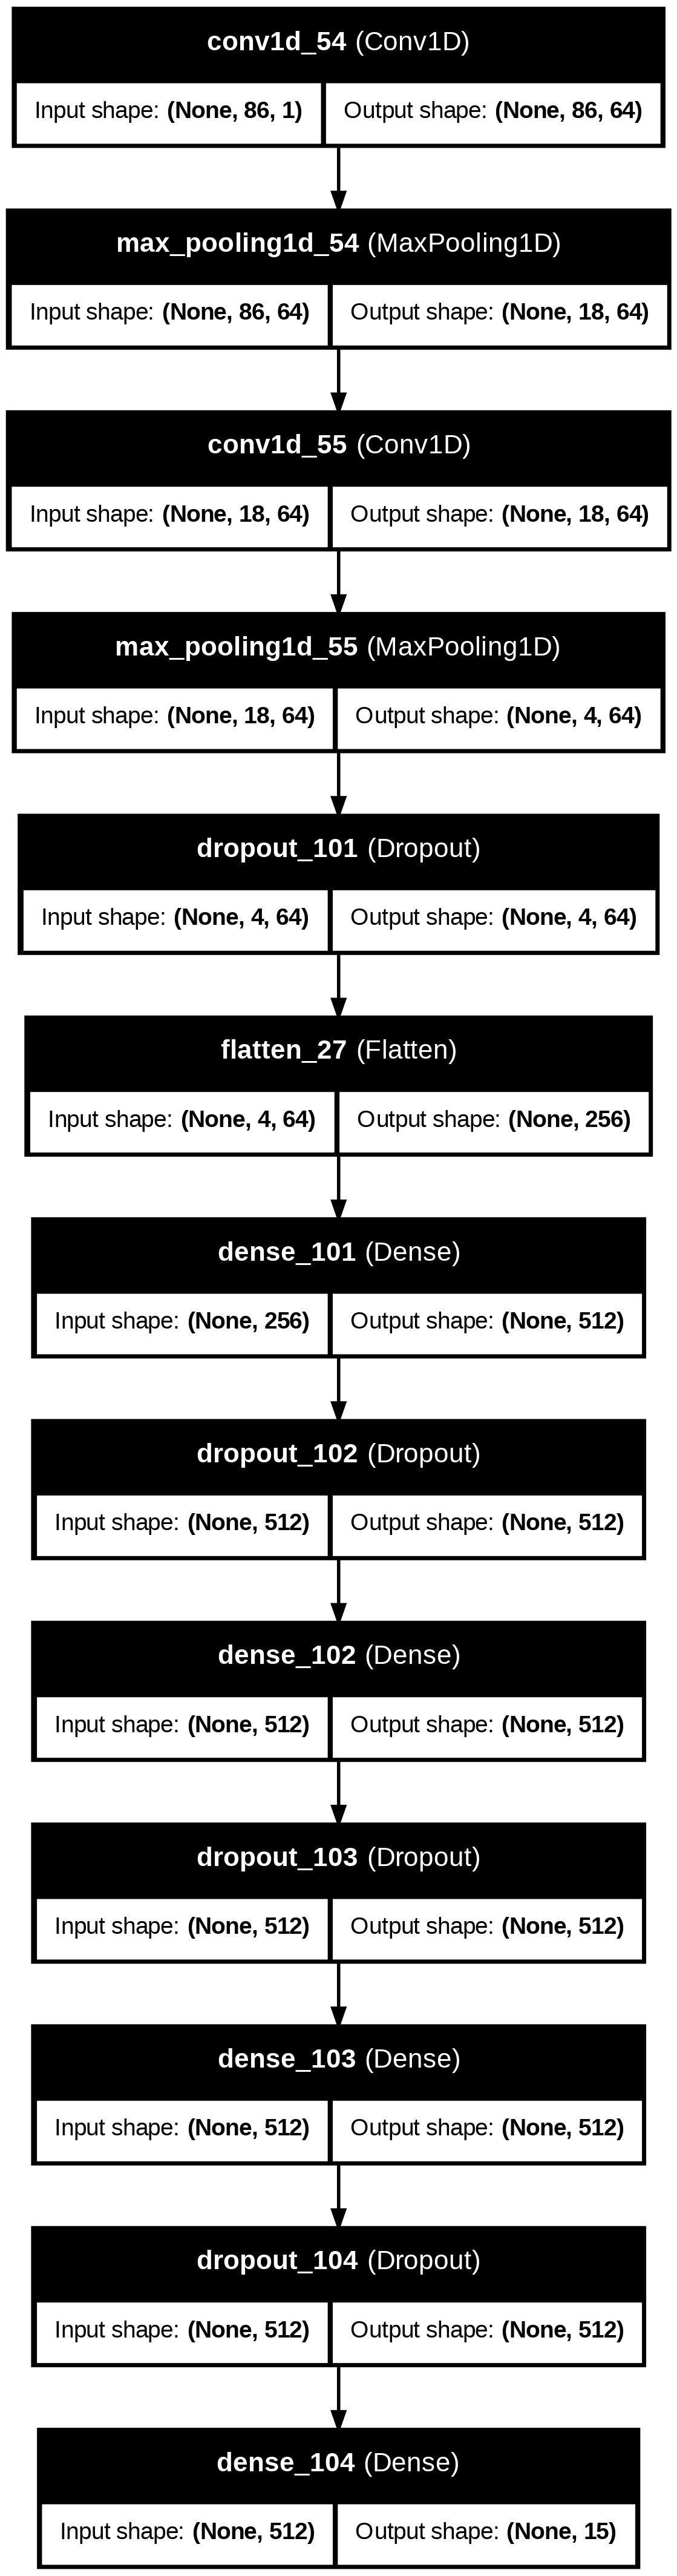

In [17]:
# Vẽ kiến trúc mô hình
plot_model(best_model, to_file='cnn_pso_model.png', show_shapes=True, show_layer_names=True)

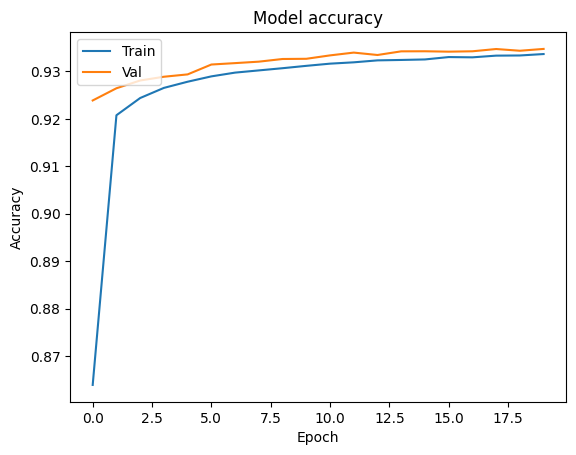

<Figure size 640x480 with 0 Axes>

In [18]:
# Vẽ biểu đồ độ chính xác huấn luyện và xác thực
plt.plot(best_model_history['accuracy'])
plt.plot(best_model_history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('acc_plot.png')

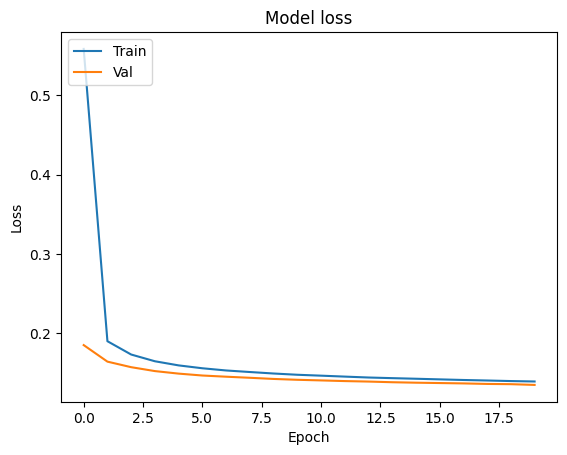

<Figure size 640x480 with 0 Axes>

In [19]:
# Vẽ biểu đồ mất mát huấn luyện và xác thực
plt.plot(best_model_history['loss'])
plt.plot(best_model_history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()
plt.savefig('los_plot.png')

In [20]:
# Đánh giá mô hình trên tập huấn luyện
train_metrics = best_model.evaluate(X_train, y_train, verbose=1)

42036/42036 ━━━━━━━━━━━━━━━━━━━━ 82s 2ms/step - accuracy: 0.9353 - f1_score: 0.6827 - loss: 0.1348 - precision_27: 0.9703 - recall_27: 0.9086


In [21]:
# Đánh giá mô hình trên tập xác thực
val_metrics = best_model.evaluate(X_val, y_val, verbose=1)

6006/6006 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.9335 - f1_score: 0.6791 - loss: 0.1366 - precision_27: 0.9692 - recall_27: 0.9073


In [22]:
# Đánh giá mô hình trên tập kiểm tra
start_time = time.time()
print("Model performance on test dataset:")
test_metrics = best_model.evaluate(X_test, y_test, verbose=1)
end_time = time.time()
test_time = end_time - start_time
print(f"Thời gian đánh giá mô hình: {test_time:.2f} giây")

Model performance on test dataset:
12011/12011 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9357 - f1_score: 0.6838 - loss: 0.1341 - precision_27: 0.9701 - recall_27: 0.9090
Thời gian đánh giá mô hình: 24.13 giây


In [23]:
# Dự đoán trên tập kiểm tra
start_time = time.time()
y_pred = best_model.predict(X_test)
total_inference_time = time.time() - start_time
print(f"\nTổng thời gian dự đoán cho tập kiểm tra: {total_inference_time:.4f} giây")

12011/12011 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step

Tổng thời gian dự đoán cho tập kiểm tra: 22.6602 giây


In [24]:
# Tính thời gian suy luận trung bình cho mỗi mẫu
num_samples = X_test.shape[0]
avg_inference_time = (total_inference_time / num_samples) * 1000  # chuyển đổi sang mili giây
print(f"\nThời gian suy luận trung bình trên mỗi mẫu: {avg_inference_time:.6f} ms")


Thời gian suy luận trung bình trên mỗi mẫu: 0.058960 ms


In [25]:
# Báo cáo phân loại
print(classification_report(y_test, np.round(y_pred)))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84      4805
           1       0.76      0.91      0.83      9709
           2       1.00      0.99      0.99     13588
           3       0.69      0.99      0.81     10013
           4       1.00      1.00      1.00     24314
           5       0.88      0.65      0.75      1706
           6       1.00      1.00      1.00       712
           7       1.00      1.00      1.00    272800
           8       0.84      0.15      0.26      9987
           9       0.00      0.00      0.00      3995
          10       0.98      0.24      0.39      2156
          11       0.64      0.18      0.28     10165
          12       1.00      0.16      0.27      7361
          13       0.94      0.85      0.89     10005
          14       0.73      0.05      0.09      3013

   micro avg       0.97      0.91      0.94    384329
   macro avg       0.81      0.61      0.63    384329
weighted avg       0.95   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


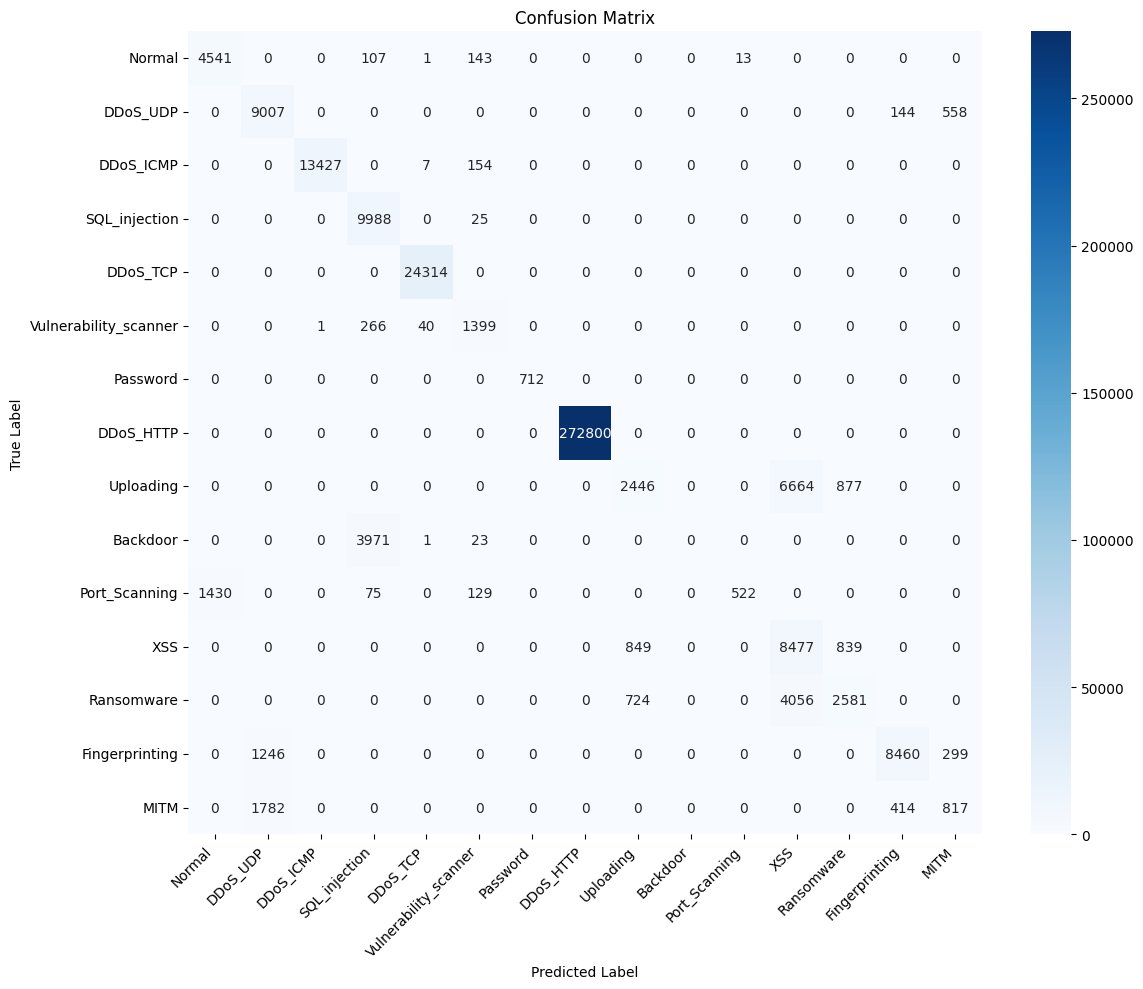

In [26]:
# Ma trận nhầm lẫn
# Lấy nhãn các lớp
class_labels = [
    'Normal', 'DDoS_UDP', 'DDoS_ICMP', 'SQL_injection', 'DDoS_TCP', 
    'Vulnerability_scanner', 'Password', 'DDoS_HTTP', 'Uploading', 
    'Backdoor', 'Port_Scanning', 'XSS', 'Ransomware', 
    'Fingerprinting', 'MITM'
]

# Chuyển đổi dự đoán sang nhãn lớp
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Tạo ma trận nhầm lẫn
conf_mat = confusion_matrix(y_test_classes, y_pred_classes)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(12, 10))  # Điều chỉnh kích thước để hiển thị rõ
sns.heatmap(
    conf_mat, 
    annot=True,  # Hiển thị số lượng 
    fmt='d',     # Định dạng số nguyên
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix.png')
plt.show()

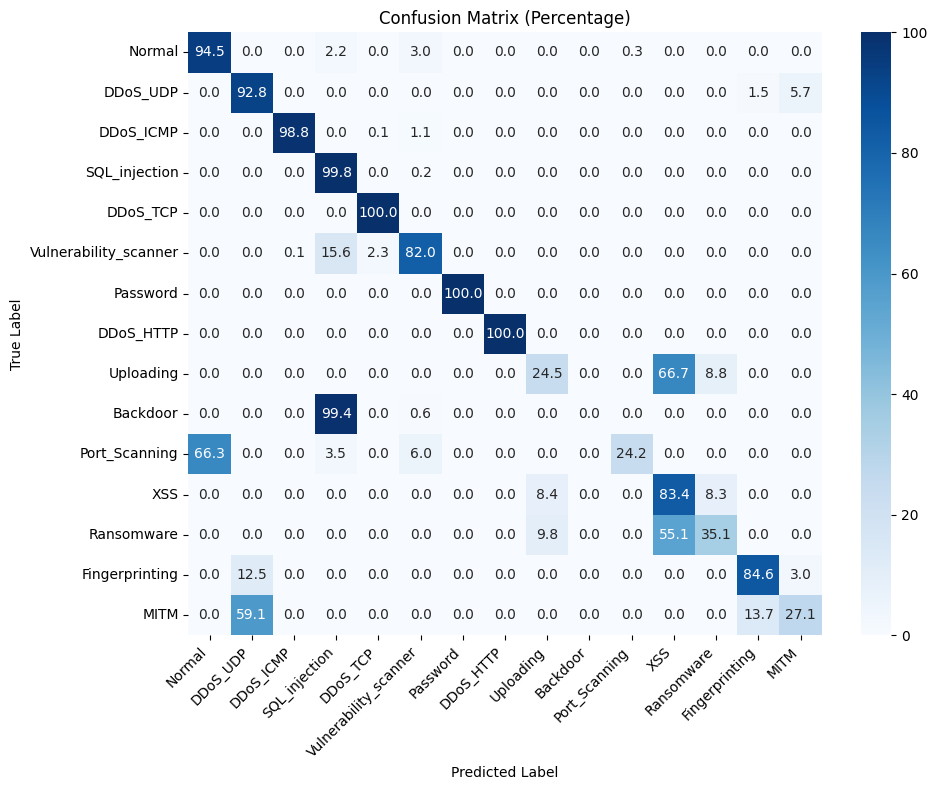

In [27]:
# Ma trận nhầm lẫn với tỷ lệ phần trăm
# Chuyển đổi sang tỷ lệ phần trăm
conf_mat_percent = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(10, 8))  # Tăng kích thước để hiển thị rõ
sns.heatmap(
    conf_mat_percent, 
    annot=True,  # Hiển thị số liệu 
    fmt='.1f',   # Định dạng 1 chữ số thập phân
    cmap='Blues', 
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Percentage)')
plt.xticks(rotation=45, ha='right')  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()  # Điều chỉnh bố cục để không bị cắt nhãn
plt.savefig('confusion_matrix_percentage.png')
plt.show()

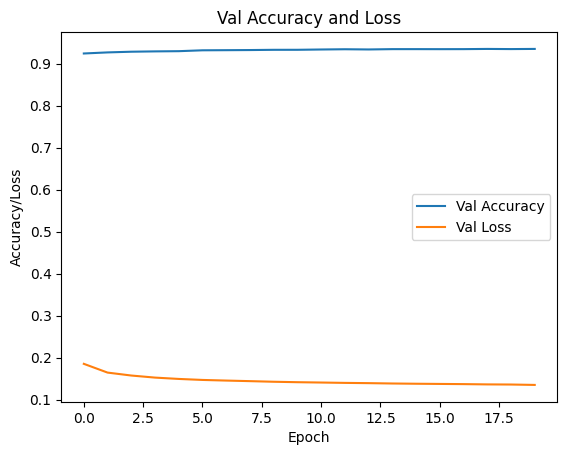

<Figure size 640x480 with 0 Axes>

In [28]:
# Độ chính xác và mất mát trên tập kiểm tra qua các epoch
test_acc = best_model_history['val_accuracy']
test_loss = best_model_history['val_loss']
plt.plot(test_acc, label='Val Accuracy')
plt.plot(test_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy/Loss')
plt.title('Val Accuracy and Loss')
plt.legend()
plt.show()
plt.savefig('val_acc_los.png')